```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization

from demos.realisticSimulations import norkyst_plotting

In [3]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 0, 0)
Driver version 10000
Using 'GeForce GTX 780' GPU
Created context handle <94172106916080>


# Select area and result folder

In [4]:
importlib.reload(NetCDFInitialization)

#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200
download_data = True
timestep_indices = None

case_name = 'lofoten'
case = NetCDFInitialization.getCaseLocation(case_name)

# Parameter to control the frequency of writing to NetCDF. Given in number of entries per hour
netcdf_frequency = 1

# How many cells to erode of land
erode_land=1

out_folder = os.path.join(datetime.date.today().isoformat(), case_name)

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '2019-11-26/lofoten'


# Inspect URL and select area

In [5]:
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

url_list = [
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc'
]


print('url_list: ', url_list)

url_list:  ['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc']


# Helpers for plotting and running simulation

In [6]:
def ncSimulation(sim, filename, timesteps, interior_domain_only, num_substeps=3, force_run=False):
    if (os.path.isfile(filename) and not force_run):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = var['Hm'][:,:]

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]        
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        progress = Common.ProgressPrinter(5)
        pp = display(progress.getPrintString(0), display_id=True)
        for i, timestep_size in enumerate(timestep_sizes):
            #Don't simulate if first step (store initial conditions also)
            if (timestep_size > 0):
                substep_size = timestep_size / num_substeps
                for j in range(num_substeps):
                    sim.updateDt()
                    sim.step(substep_size)

            var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
            ncvar['time'][i] = sim.t
            ncvar['num_iterations'][i] = sim.num_iterations

            abort=False
            for varname in ['eta', 'hu', 'hv']:
                ncvar[varname][i,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                if (np.any(np.isnan(var[varname]))):
                    print("Variable " + varname + " contains NaN values!")
                    abort=True

            if (abort):
                print("Aborting at t=" + str(sim.t))
                ncfile.sync()
                break

            pp.update(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

# Plot reference solution

In [7]:
url_list[0]

'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

num_files:  5
source_url_list
['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc']
got data from the first file. eta.shape:  (2, 300, 500)


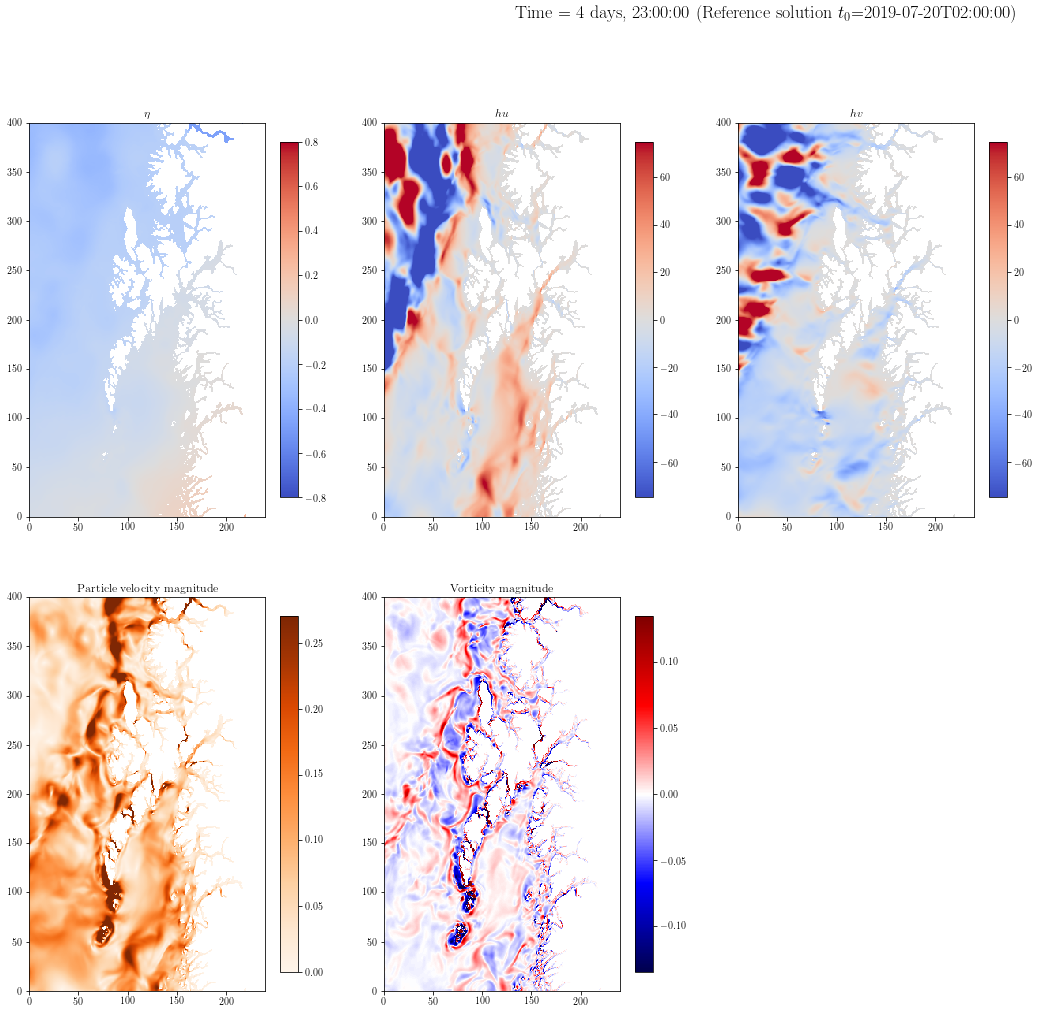

In [8]:
importlib.reload(norkyst_plotting)
norkyst_plotting.refAnimation(url_list, case,
         movie_frames=movie_frames, 
         timestep_indices=timestep_indices, 
         create_movie=create_movie,
         fig=plt.figure(figsize=(18,16)),
         h_max=0.8, h_min=-0.8, 
         uv_max=75, uv_min=-75, 
         add_extra=2,
         rotate=True, 
         downsample=4)

# Run original resolution simulation

In [9]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
}

In [10]:
importlib.reload(NetCDFInitialization)

data_args = NetCDFInitialization.getInitialConditionsNorKystCases(url_list, 'lofoten', 
                                                                  timestep_indices=None, #timestep_indices[9],
                                                                  erode_land=erode_land,
                                                                  download_data=False)

print(data_args['timesteps']/3600)
print(data_args['note'])
print(data_args['wind_stress'].t/3600)
print(data_args['boundary_conditions_data'].t/3600)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]
2019-11-26T15:52:49.246587: Generated from ['/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc', 'ht

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

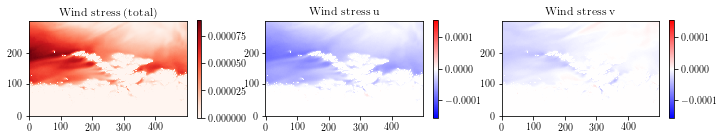

In [11]:
    
norkyst_plotting.animateWind(data_args['wind_stress'], create_movie=create_movie)

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

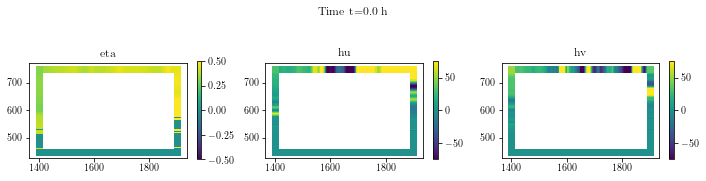

In [12]:

norkyst_plotting.bcAnimation(data_args['boundary_conditions_data'], 
                             case['x0'], case['x1'], case['y0'], case['y1'], create_movie=create_movie)

In [13]:

#Add substeps for netcdf
if netcdf_frequency > 1:    
    n_timesteps = len(data_args['timesteps'])
    x = np.linspace(0, 1, n_timesteps)
    y = data_args['timesteps']
    x_interp = np.linspace(0, 1, n_timesteps*netcdf_frequency)
    y_interp = np.interp(x_interp, x, y)
    data_args['timesteps'] = y_interp

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

original_filename = os.path.join(out_folder, case_name + "_original.nc")
ncSimulation(sim=sim, 
             filename=original_filename,
             timesteps=data_args['timesteps'],
             interior_domain_only=False)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


File 2019-11-26/lofoten/lofoten_original.nc already exists, skipping simulation.


'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

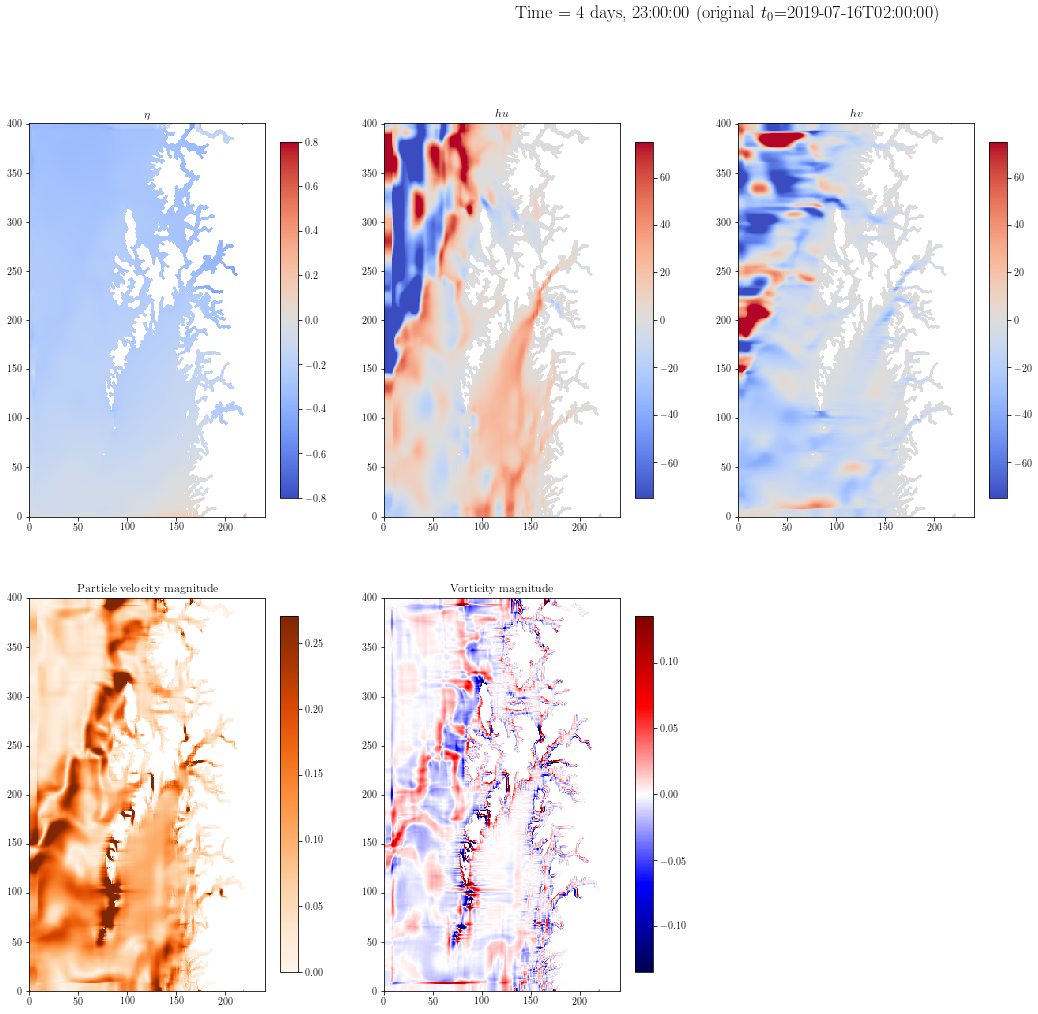

In [14]:
norkyst_plotting.ncAnimation(original_filename,
             title="original $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True, 
             downsample=2)